In [2]:
import random as rd

Variant = 8
rd.seed(Variant+4335)

Numbers_of_problems = [rd.sample(range(5),1)[0]+1, rd.sample(range(5),1)[0]+1, rd.sample(range(5),1)[0]+1]
Numbers_of_problems

[3, 1, 5]

## Task 1
#### Перейти в каталог sandbox
cd sandbox

#### Создать архив MyArch.tar с файлами Task_1, Task_2, Task_3
tar -cf MyArch.tar Task_1 Task_2 Task_3

#### Сжать архив с помощью gzip
gzip MyArch.tar

#### Перенаправить список содержимого каталога sandbox в файл List
ls > List

#### Распаковать архив, чтобы добавить файл List
gzip -d MyArch.tar.gz

#### Добавить файл List в архив
tar -rf MyArch.tar List

#### Снова сжать архив
gzip MyArch.tar


## Task 2

```ASM
format ELF64

public _start

macro cout _data, _length {
    push rax
    push rbx
    push rdx
    push rsi
        mov rax, 1
        mov rbx, 1
        mov rsi, _data
        mov rdx, _length
        syscall
    pop rsi
    pop rdx
    pop rbx
    pop rax
}

macro cin _bufferInput, _length {
    push rbx
    push rdx
    push rsi
    push rdi
        mov rax, 0
        mov rbx, 0
        mov rsi, _bufferInput
        mov rdx, _length
        syscall

        cmp rax, rdx
        jb .inputNormal

        .flush:
            mov rax, 0
            mov rbx, 0
            mov rsi, _bufferInput       ; временный буфер
            mov rdx, 1                  ; читаем по 1 символу
            syscall
            
            cmp rax, 1
            jne .flushed
            cmp byte [rsi], 10          ; дошли до '\n'
            jne .flush

        .flushed:
            mov rax, -1
            jmp invalidLengthInput

        .inputNormal:
            dec rax
            mov rdi, _bufferInput
            add rdi, rax
            mov byte [rdi], 0
    pop rdi
    pop rsi
    pop rdx
    pop rbx
}

section '.function' executable
    ; input - address char rax
    ; output - int rcx
    CastCharInt:
        push rbx
        push rdi
            ; check a minus
            xor rbx, rbx
            cmp byte [rax], '-'
            sete bl ; if equal bl = 1, else bl = 0

            ; skip a minus
            cmp bl, 1
            jne .startConvert
            inc rax

            .startConvert:
                xor rcx, rcx
            .cycleConvert:
                movzx rdi, byte [rax]
                add rcx, rdi
                sub rcx, '0'
                inc rax

                cmp byte [rax], 0
                je .cycleConvertEnd

                imul rcx, 10
                jmp .cycleConvert
            .cycleConvertEnd:

            cmp bl, 1
            jne .return

            imul rcx, -1

            .return:
        pop rdi
        pop rbx
        ret
    
    ; input - int rax
    ; output - bufferOutput
    CastIntChar:
    push rcx
    push rdi
    push rdx
    push rbx
    push rsi
        ; check a sign
        xor rbx, rbx
        cmp rax, 0
        jge .positive
        
        ; negative
        mov rbx, 1              ; negative flag
        neg rax                 ; make positive
    
        .positive:
            ; find number length
            push rax
            push rbx            ; save sign flag
                mov rcx, 0
                mov rsi, 10
                
                test rax, rax   ; if zero number
                jnz .cycleIntLen
                mov rcx, 1      ; size 1 for zero number
                jmp .CycleDone
                
                .cycleIntLen:
                    xor rdx, rdx
                    div rsi
                    inc rcx
                    test rax, rax
                    jnz .cycleIntLen
                .CycleDone:
            pop rbx             ; restore sign flag
            pop rax
            
            ; consider sign in size
            test rbx, rbx
            jz .unsign
            inc rcx
            
        .unsign:
            push rbx            ; save sign flag
                mov rsi, 10
                mov rdi, bufferOutput
                add rdi, rcx
                mov byte [rdi], 0
                dec rdi
                
                .cycleConverter:
                    xor rdx, rdx
                    div rsi
                    add dl, '0'
                    mov byte [rdi], dl
                    dec rdi
                    test rax, rax
                    jnz .cycleConverter
            .conversionDone:
            pop rbx
            
            ; add sign
            test rbx, rbx
            jz .return
            mov byte [rdi], '-'
            
        .return:
            mov qword [lengthOutput], rcx
    pop rsi
    pop rbx
    pop rdx
    pop rdi
    pop rcx
    ret

section '.data' writeable
    messageInvalidInput:
        db 0x1B, '[H', 0x1B, '[J'
        db 'Error', 10, 10
    messageInvalidInputEnd:
    kLengthMessageInvalidInput equ messageInvalidInputEnd - messageInvalidInput

    newLine db 10

    lengthInput dq 0
    lengthOutput dq 0

section '.bss' writeable
    bufferInput rb 256
    bufferOutput rb 256
    fileInput rb 8
    fileOutput rb 8
    fileDiscriptorInput rb 8
    fileDiscriptorOutput rb 8

section '.error' executable
    invalidLengthInput:
        cout messageInvalidInput, kLengthMessageInvalidInput
        jmp _start

section '.text' executable    
_start:
    cin bufferInput, 256
    mov qword [lengthInput], rax

    mov rax, bufferInput
    call CastCharInt

    push rax
        mov rax, rcx
        mov rbx, 2
        xor rdx, rdx
        div rbx
        cmp rdx, 0
        je returnError
    pop rax

    push rcx
    push r8
        xor rax, rax
        mov r8, 1
        .cycle:
            add rax, r8
            add r8, 2
            cmp r8, rcx
            jle .cycle
    pop r8
    pop rcx

    push rax
        xor r8, r8
        mov rbx, 10
        .cycleLength:
            xor rdx, rdx
            div rbx
            inc r8
            cmp rdx, 0
            jne .cycleLength
    pop rax

    mov qword [lengthOutput], r8

    call CastIntChar

    cout bufferOutput, lengthOutput

    cout newLine, 1

    return:
        mov rax, 60
        xor rdi, rdi
        syscall

    returnError:
        cout messageInvalidInput, kLengthMessageInvalidInput
        mov rax, 60
        mov rdi, 1
        syscall


## Task 3

```ASM
format ELF64

public _start

section '.data' writeable
    dir_fd       dq 0
    bytes_read   dq 0
    dir_buffer   rb 4096
    path_buffer  rb 256
    dir_name_buf rb 256

section '.text' executable

_start:
    cmp     qword [rsp], 2
    jne     exit_error

    mov     rdi, dir_name_buf
    mov     rsi, [rsp+16]
    call    strcpy

    mov     rax, 2
    mov     rdi, dir_name_buf
    mov     rsi, 0x10000
    xor     rdx, rdx
    syscall
    cmp     rax, 0
    jl      exit_error
    mov     [dir_fd], rax

    mov     rax, 217
    mov     rdi, [dir_fd]
    mov     rsi, dir_buffer
    mov     rdx, 4096
    syscall
    cmp     rax, 0
    jle     .cleanup
    mov     [bytes_read], rax

    mov     rbx, dir_buffer
    mov     rcx, 3

.main_loop:
    cmp     rcx, 0
    je      .cleanup

    mov     rax, rbx
    sub     rax, dir_buffer
    cmp     rax, [bytes_read]
    jge     .cleanup

    cmp     byte [rbx+18], 8
    jne     .next_entry

    call    build_full_path

    rdrand  rdx
    and     rdx, 777o

    mov     rax, 90
    mov     rdi, path_buffer
    mov     rsi, rdx
    syscall

    dec     rcx

.next_entry:
    movzx   rdx, word [rbx+16]
    add     rbx, rdx
    jmp     .main_loop

.cleanup:
    mov     rax, 3
    mov     rdi, [dir_fd]
    syscall
    call    exit

build_full_path:
    mov     rdi, path_buffer
    mov     rsi, dir_name_buf
.copy_dir:
    mov     al, [rsi]
    mov     [rdi], al
    inc     rsi
    inc     rdi
    test    al, al
    jnz     .copy_dir
    dec     rdi

    mov     byte [rdi], '/'
    inc     rdi

    mov     rsi, rbx
    add     rsi, 19
.copy_file:
    mov     al, [rsi]
    mov     [rdi], al
    inc     rsi
    inc     rdi
    test    al, al
    jnz     .copy_file
    ret

strcpy:
.loop:
    mov     al, [rsi]
    mov     [rdi], al
    inc     rsi
    inc     rdi
    test    al, al
    jnz     .loop
    ret

exit_error:
    mov     rax, 60
    mov     rdi, 1
    syscall

exit:
    mov     rax, 60
    xor     rdi, rdi
    syscall


## CodeTest Task 3
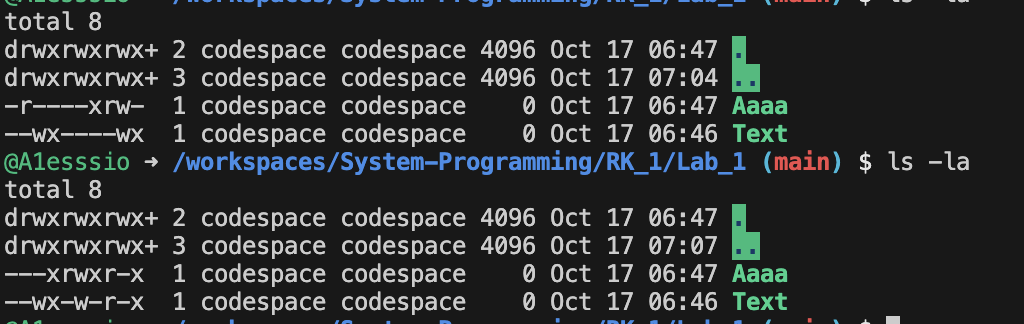

## CodeTest Task 2
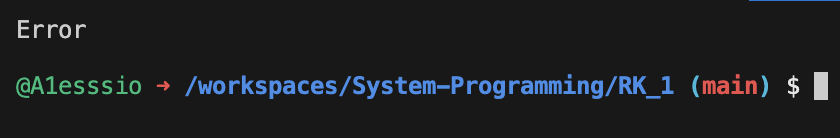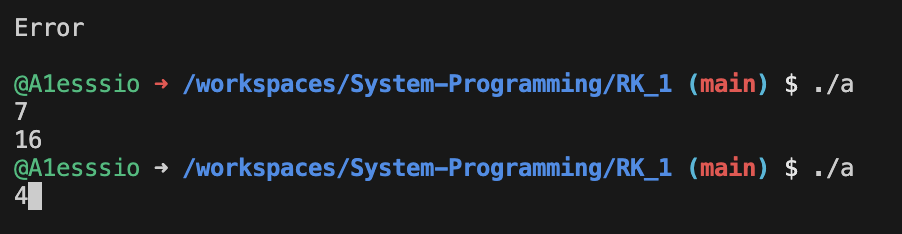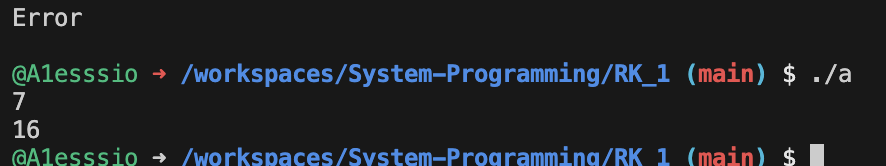